In [1]:
import linmix.linmix as linmix
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import corner
#from labellines import labelLine, labelLines
import emcee

In [2]:
def fit_line_linmix(x, y, xerr, yerr, nchains=4, seed=None):
    """
    Fit line using LinMix
    """ 
    lm = linmix.LinMix(x, y, xsig=None, ysig=yerr, K=2, nchains=nchains, seed=seed)
    lm.run_mcmc(silent=True)

    # Print results
    samples = lm.chain
    print("m = {0:.2} ± {1:.2}".format(np.mean(samples['beta']), np.std(samples['beta'])))
    print("b = {0:.2} ± {1:.2}".format(np.mean(samples['alpha']), np.std(samples['alpha'])))
    print("sigma [dex] = {0:.2} ± {1:.2}".format(np.mean(np.sqrt(samples['sigsqr'])), np.std(np.sqrt(samples['sigsqr']))))
    print("corr = {0:.2} ± {1:.2}".format(np.mean(samples['corr']), np.std(samples['corr'])))
    
    return samples

def draws_CI_linmix(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i,s in enumerate(samples):
        draws[:, i]  = s['alpha'] + x_eval*s['beta']

    # Compute credibility interval
    draws_credint = np.empty((len(x_eval), 3))
    draws_credint[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint[:, 1] = np.median(draws, axis=1)
    
    return draws_credint


In [3]:
data=np.loadtxt("tau_obs-z.dat")
z=data[:,6]
tau_o=data[:,3]
tau_ouerr=data[:,4]
tau_olerr=data[:,5]

x=np.log10(1.+z)
y=np.log10(tau_o)
print (np.shape(y))
yerr_u=(1./np.log(10))*tau_ouerr/tau_o
yerr_l=(1./np.log(10))*tau_olerr/tau_o

(89,)


m = -0.091 ± 0.25
b = 1.6 ± 0.069
sigma [dex] = 0.28 ± 0.028
corr = -0.044 ± 0.12


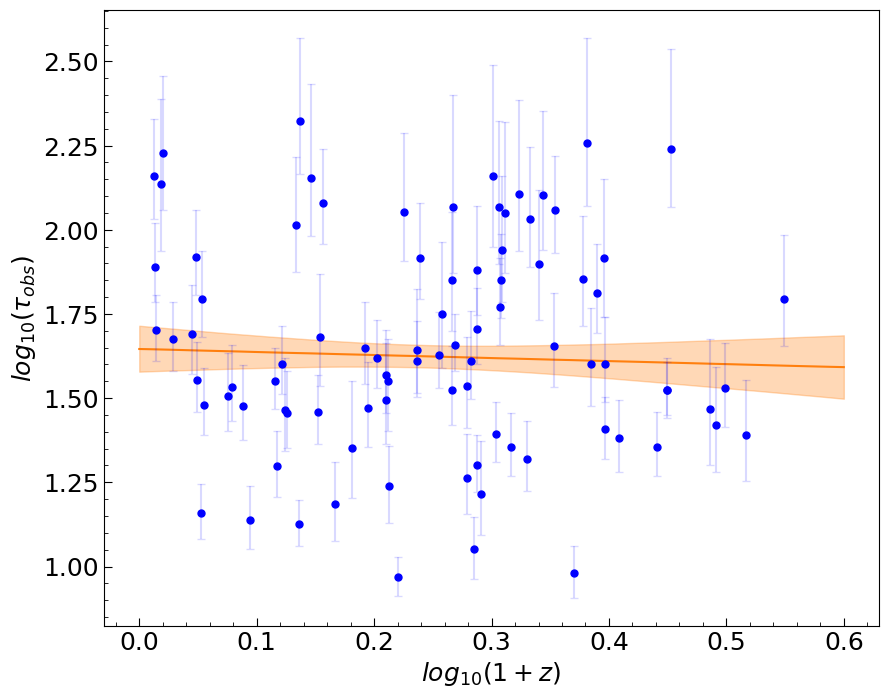

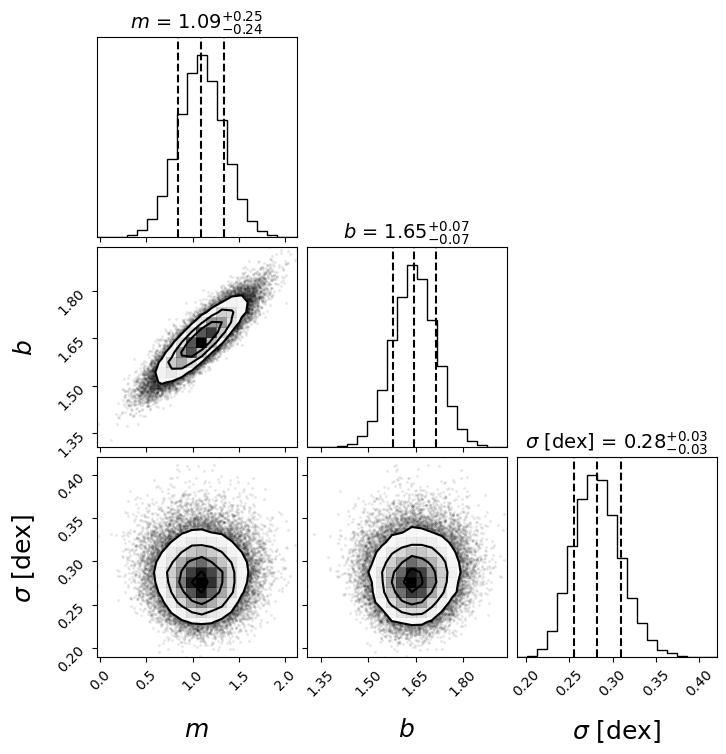

In [4]:
plt.figure(figsize=(10,8),dpi=100, frameon=True)
m,c,b = plt.errorbar(x, y, 
                     yerr=[yerr_l,yerr_u], 
                    linestyle='', fmt='bo', ms=5,
                    ecolor='b', capsize=3, zorder=-1)
plt.xlabel('$log_{10}(1+z)$', size=18)
plt.ylabel('$log_{10}(\\tau_{obs})$',size=18)

[i.set_alpha(0.15) for i in b]
[i.set_alpha(0.15) for i in c]
xerr=np.arange(0,0,len(x))

samples = fit_line_linmix(x, y, xerr=xerr, yerr=(yerr_l+yerr_u)/2., nchains=16, seed=50)
x_eval = np.linspace(0,0.6,50)
draws_credint = draws_CI_linmix(x_eval, samples)

plt.fill_between(x_eval, draws_credint[:, 2], draws_credint[:, 0],
                color="#ff7f0e", alpha=0.3, zorder=-5)
plt.plot(x_eval, draws_credint[:, 1], color="#ff7f0e", zorder=-4)
plt.tick_params('both',labelsize=18)

plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in')
plt.tick_params(axis='both', which='major', length=6)
plt.tick_params(axis='both', which='minor', length=3)
plt.savefig("tau-(1+z).pdf")

fig = corner.corner(np.array([1.-samples['beta'], samples['alpha'], np.sqrt(samples['sigsqr'])]).T,
             labels=["$m$", "$b$", "$\sigma$ [dex]"], quantiles=[0.16,0.5,0.84], show_titles=True,
             label_kwargs=dict(fontsize=18), title_kwargs=dict(fontsize=14))
plt.savefig("param.pdf")

np.savetxt('cel_'+'_parSamples.txt', np.array([samples['beta'], samples['alpha'], np.sqrt(samples['sigsqr'])]).T)